# Reproduce subsampling from `loo` the R package

## Background
This is a Notebook for testing LOO-CV with subsampling. This script to trying to reproduce the subsampling method that has been implemented in `R` using `pymc3`.

The demostration of R package `loo` is from [here](https://mc-stan.org/loo/articles/loo2-large-data.html).

The workflow of subsampling in R is roughly shown below:

<div>
<img src="logic_loo_subsampling.png" width="600"/>
</div>


To convert the `r` script to python, the first step is to reproduce this demo model, then calculate the relative effective sample size (`r_eff`), then start the subsampling method.

## Step 1: Reproduce the logistic regression

We use the `pm.glm.GLM` for now (but will use `bambi` in the future).

In [2]:
import warnings

from collections import OrderedDict
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano as thno
import theano.tensor as T

from scipy import integrate
from scipy import stats
from scipy.optimize import fmin_powell

print(f"Running on PyMC3 v{pm.__version__}")

warnings.filterwarnings("ignore") # ignore warnings

Running on PyMC3 v3.11.4


In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [4]:
def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    with model:
        ax = az.plot_trace(
            traces[-retain:],
            lines=tuple([(k, {}, v["mean"]) for k, v in az.summary(traces[-retain:]).iterrows()]),
        )

        for i, mn in enumerate(az.summary(traces[-retain:])["mean"]):
            ax[i, 0].annotate(
                f"{mn:.2f}",
                xy=(mn, 0),
                xycoords="data",
                xytext=(5, 10),
                textcoords="offset points",
                rotation=90,
                va="bottom",
                fontsize="large",
                color="#AA0022",
            )

In [5]:
data = pd.read_csv("wells.csv")
data.head(10)

,switch,arsenic,dist,assoc,educ,dist100
0,1,2.36,16.826000,0,0,0.16826
1,1,0.71,47.321999,0,0,0.47322
2,0,2.07,20.966999,0,10,0.20967
3,1,1.15,21.486000,0,12,0.21486
4,1,1.10,40.874001,1,14,0.40874
5,1,3.90,69.517998,1,9,0.69518
6,1,2.97,80.710999,1,4,0.80711
7,1,3.24,55.146000,0,10,0.55146
8,1,3.28,52.646999,1,0,0.52647
9,1,2.52,75.071999,1,0,0.75072


### The model

The model is a simple logistic regression model, the formula is as below:

`switch ~ 1 + dist100 + arsenic`

In [6]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        "switch ~ 1 + dist100 + arsenic", data, family=pm.glm.families.Binomial()
    
    )
    
    trace = pm.sample(1000, tune=1000, init="adapt_diag")

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [arsenic, dist100, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


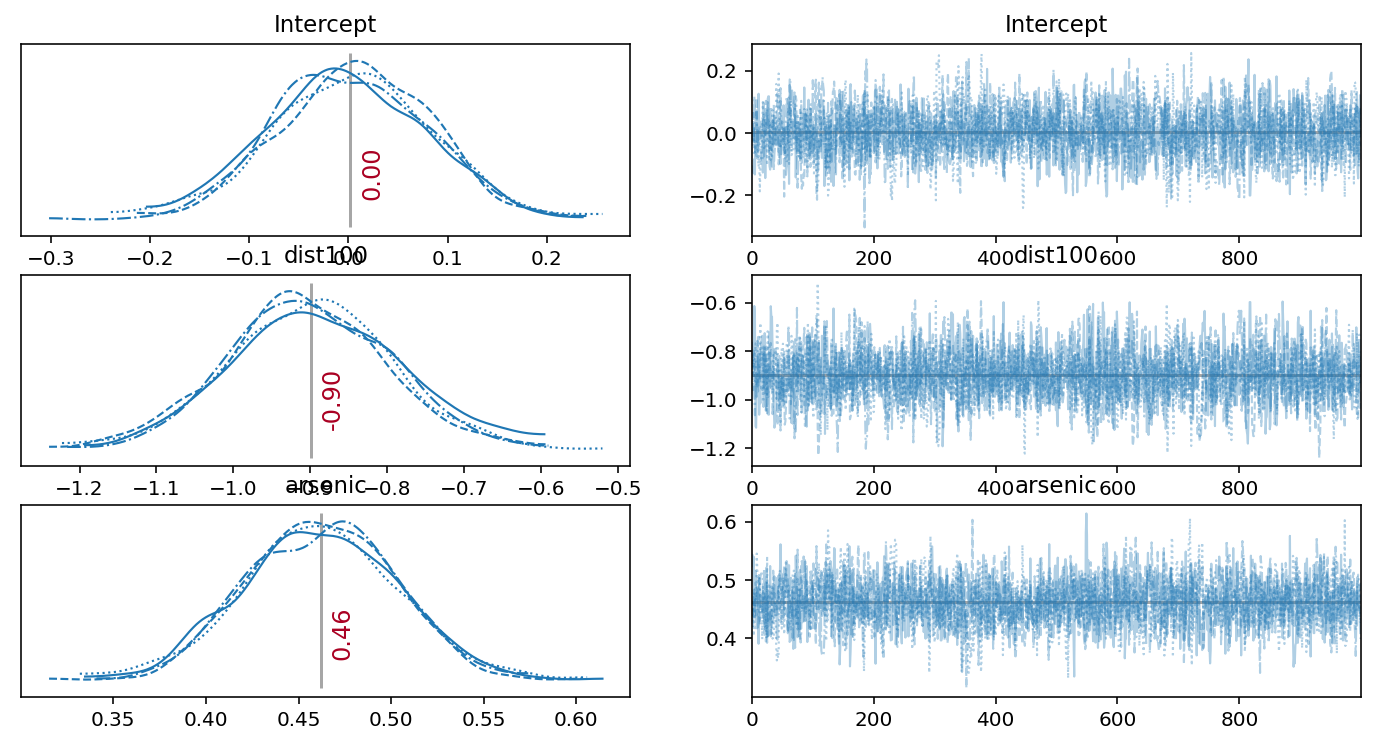

In [7]:
plot_traces(trace, logistic_model)

### Convert to `InferenceData`

In [8]:
dims = {"y": ["switch"]}
idata_kwargs = {
    "dims": dims,
}
idata = az.from_pymc3(trace, model=logistic_model, **idata_kwargs)

### Compare the posterior with results from `Stan` in R

In [9]:
map_estimate = pm.find_MAP(model=logistic_model)
map_estimate

{'Intercept': array(0.00274998),
 'dist100': array(-0.89664381),
 'arsenic': array(0.46077421)}

The results from `pymc3` are similar to that from `stan` in R:

```
         mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
beta[1]  0.00       0 0.08 -0.15 -0.05  0.00  0.05  0.16  1992    1
beta[2] -0.89       0 0.11 -1.09 -0.96 -0.89 -0.82 -0.68  2182    1
beta[3]  0.46       0 0.04  0.38  0.43  0.46  0.49  0.54  1598    1
```

In [10]:
draws = idata.posterior

print("Means of coefficients of arsenic is: ", np.mean(draws['arsenic']))

Means of coefficients of arsenic is:  <xarray.DataArray 'arsenic' ()>
array(0.46191004)


### Get the `loo` of the model

We can directly use `loo` in R or `az.loo()` in python to diagnoise the model. this step is not necessary for big data. 

Using `az.loo()` to calculate the loo, without `subsampling`. The results is comparable with that from R:

```
Computed from 4000 by 3020 log-likelihood matrix

         Estimate   SE
elpd_loo  -1968.5 15.6
p_loo         3.3  0.1
looic      3937.0 31.2
```

Note that the `loo` function in python did not include SE of `p_loo`, which needs to be added in the future.

In [11]:
loo_value = az.loo(idata, pointwise=True)
loo_value

Computed from 4000 by 3020 log-likelihood matrix

         Estimate       SE
elpd_loo -1968.42    15.66
p_loo        3.19        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3020  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

We can also check the diagnostic value `pareto k`:

In [12]:
loo_value.pareto_k

<xarray.DataArray 'pareto_shape' (switch: 3020)>
array([-0.11683007, -0.11724412, -0.07126305, ...,  0.01398452,
       -0.01947886, -0.09139533])
Coordinates:
  * switch   (switch) int64 0 1 2 3 4 5 6 ... 3013 3014 3015 3016 3017 3018 3019

## Reproduce (part of) R function `loo_subsample`

Now, let's reproduce the function of the default setting of the  `loo_subsample` in python.

### Step 1: Get all the elements

The default setting of `loo_subsample` does not need appromixation methods and include the following inputs:

```
  loo_subsample(
    llfun_logistic,
    observations = 100, # take a subsample of size 100
    cores = 2,
    # these next objects were computed above
    r_eff = r_eff, 
    draws = parameter_draws_1,
    data = stan_df_1
  )
```

#### log likelihood function: llfun_logistic
Note that in the R example, usually the `llfun`, log likelihood function, is directly used as the input, here we may need to specify this function.

It is tempting to use the pointwise logliklihood in the `idata` directly, but there is a twist here.

#### data


#### draws (posteriors):

#### observations (number of subsamples)

#### `r_eff` (left for future)

Relative effective sample size, which is a bit tricky.

In R, the [code for `r_eff` is]( https://github.com/stan-dev/loo/blob/master/R/effective_sample_sizes.R#L34):

```
relative_eff(llfun_logistic, 
             log = FALSE, # relative_eff wants likelihood not log-likelihood values
             chain_id = rep(1:4, each = 1000), 
             data = stan_df_1, 
             draws = parameter_draws_1, 
             cores = 4)
```

The core function of this `S3` object is [`ess_rfun`](https://github.com/stan-dev/loo/blob/master/R/effective_sample_sizes.R#L201)

**Importantly**,the `log = FALSE` argument might cause the inconsistent results between `relative_eff` and `_ess` in python? However, testing with or without `np.exp()` does not change the results.

In `az.loo` the relative effective sample size is calculated internally as [`reff`](https://github.com/arviz-devs/arviz/blob/v0.11.4/arviz/stats/stats.py#L683). Thus, in `az.loo`, we do not need to calculate `r_eff` separately and use it as input, so here I skipped calculation of `r_efff` for now.

In [13]:
# model_ex = compile_linreg_model(**excluded_observed_data)
log_lik_i = idata.log_likelihood["y"]

In [14]:
log_lik_i[:,:, 0] # draws for intercept

<xarray.DataArray 'y' (chain: 4, draw: 1000)>
array([[-0.30330613, -0.30330613, -0.32088767, ..., -0.31553507,
        -0.32380151, -0.32575504],
       [-0.33943826, -0.33943826, -0.34221839, ..., -0.33998261,
        -0.34435811, -0.35081806],
       [-0.32918108, -0.34254393, -0.32646477, ..., -0.32229606,
        -0.31593093, -0.31981243],
       [-0.3504977 , -0.3244327 , -0.35109535, ..., -0.36107578,
        -0.33763923, -0.37265494]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    switch   int64 0

### Step 2: Get the point estimate

This is part of the `loo_approximation` in the `loo_subsample.R`. There are multiple ways to estimate these values, and the default is `plpd`.

* `tis` or `sis`: returns the `loo_epld` using `loo.function()` (i.e., no approximation at all)
* `lpd`: returns results of `compute_lpds`;
* `plpd`: returns results of `compute_lpds`, with an addition input of `point_est`;
* others: approximation methods.

Here I focused on the `point_est`. In this approach, the mean of draws are used: (1) calculate the mean of each columns in the posterior (i.e., the mean of posterior of each parameter); (2) convert it to a matrix (dim: 3x1 ); (3) transpose it to a 1X3 matrix. The matrix is then used for future calculation. 

This step is computing the $\hat{\theta}$ in the approximating the $\tilde{\pi} \propto -\text{log} p(y_i | \hat{\theta})$ (see section 2.5 in Magnusson et al. 2019).

Thus the `point_est` means point estimation, i.e., means value, not pointwise estimation.

In [15]:
point_est = idata.posterior.to_dataframe().mean() # convert to dataframe first, then calculate mean
point_est

Intercept    0.002088
dist100     -0.899172
arsenic      0.461910
dtype: float64

### Step 3: Get the `elpd_loo_approx`

As mentioned in step 2, there are multiple ways for approximating the `elpd_loo`. In the `loo_subsample` function, the `plpd` is the default, which uses the `compute_lpds()` function, which is essentially a wrapper for parallel procesing. 

The underlying function is `lpd_i`, which get each of the observed and calculates it log likelihood, then use function `logMeanExp()` to calculate the log mean of these likelihood. 

`copmute_lpds()` can take both the draws and mean of draws as the input. The later is `point_est` approach. When using `point_est`, the `elpd_loo_approx` is a vector of the same length as the data (here: 3020); When using `lpd`, it returns a 4000 * 3020 matrix (? I doubt here is still a vector with length of the data).

When applying to HDDM, the difficult part is generate the log-likelihood function for each model.

```
 llfun_logistic <- function(data_i, draws, log = TRUE) {
   x_i <- as.matrix(data_i[, which(grepl(colnames(data_i), pattern = "X")), drop=FALSE])
   logit_pred <- draws %*% t(x_i)
   dbinom(x = data_i$y, size = 1, prob = 1/(1 + exp(-logit_pred)), log = log)
 }

logMeanExp <- function(x) {
  logS <- log(length(x))
  matrixStats::logSumExp(x) - logS
}

lpd_i <- function(i, llfun, data, draws) {
  ll_i <- llfun(data_i = data[i,, drop=FALSE], draws = draws)
  ll_i <- as.vector(ll_i)
  lpd_i <- logMeanExp(ll_i)
  lpd_i
}

compute_lpds <- function(N, data, draws, llfun, cores) {
  if (cores == 1) {
    lpds <- lapply(X = seq_len(N), FUN = lpd_i, llfun, data, draws)
  } else {
    if (.Platform$OS.type != "windows") {
      lpds <- parallel::mclapply(X = seq_len(N), mc.cores = cores, FUN = lpd_i, llfun, data, draws)
    } else {
      cl <- makePSOCKcluster(cores)
      on.exit(stopCluster(cl))
      lpds <- parLapply(cl, X = seq_len(N), fun = lpd_i, llfun, data, draws)
    }
  }
  
  unlist(lpds)
}

elpd_loo_approx <- compute_lpds(N, data, point_est, llfun_logistic, cores=1)

elpd_loo_approximation <- elpd_loo_approx

```

We need to first generate the matrix for calculating the `lpd` for each data point.

In [16]:
data_x = data[["dist100", "arsenic", "switch"]] # select IVs
data_x["Intercept"] = 1
data_x = data_x[["switch", "Intercept", "dist100", "arsenic"]]
data_x.head()

,switch,Intercept,dist100,arsenic
0,1,1,0.16826,2.36
1,1,1,0.47322,0.71
2,0,1,0.20967,2.07
3,1,1,0.21486,1.15
4,1,1,0.40874,1.10


In [17]:
draws = idata.posterior.to_dataframe()
draws.shape

(4000, 3)

In [46]:
def llfun_logistic(data_i, draws, log = True):
    """ log likelihood for one observation """
    from scipy import stats
    import numpy as np
    
    # select preditors
    x_i = data_i[["Intercept", "dist100", "arsenic"]]
    logit_pred = np.dot(draws, np.transpose(x_i))
    
    # select dependent variables
    y_i = data_i[["switch"]]
    
        
    if log == True:
        ll_i = stats.binom.logpmf(k = y_i["switch"], n=1, p = 1/(1 + np.exp(-logit_pred)))
    else:
        ll_i = stats.binom.pmf(k = y_i["switch"], n=1, p = 1/(1 + np.exp(-logit_pred)))

    return ll_i

def logMeanExp(x):
    """ 
    get the logMeanExp
    Has compared with results from R, it's the same
    """
    import numpy as np
    
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    
    logS = np.log(x.size)               # use "size" instead of "len" to avoid error when # of element is 1
    res = np.logaddexp.reduce(x) - logS # using numpy.logaddexp replacing matrixStats::logSumExp
        
    return res
    
def lpd_i(i, llfun, data, draws):
    
    ll_i = llfun(data_i = data.iloc[i,:], draws = draws)
    lpd_i = logMeanExp(ll_i)
    return lpd_i

def compute_lpds (N, data, draws, llfun, cores):
    """ Need parallel processing in the future """
    
    if cores == 1:
        lpds = []
        for i in range(N):
            lpd_tmp = lpd_i(i, llfun, data, draws)
            lpds.append(lpd_tmp)
            
    return lpds

In [19]:
elpd_loo_approx = compute_lpds(N = data_x.shape[0],
                    data = data_x,
                    draws = point_est, 
                    llfun = llfun_logistic, 
                    cores=1)

elpd_loo_approximation = elpd_loo_approx

Plot the frequency of `elpd_loo_approx`, the distribution is similar to that in R

array([[<AxesSubplot:title={'center':'elpd_loo'}>]], dtype=object)

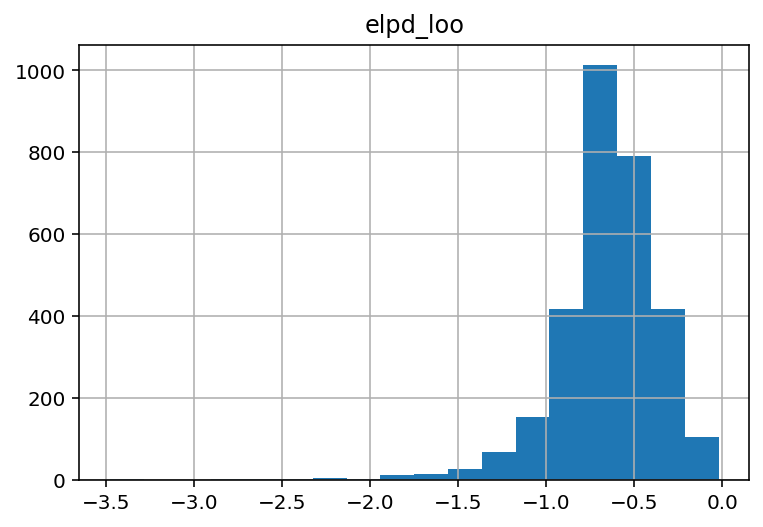

In [26]:
df_elpd_loo_approximation = pd.DataFrame (elpd_loo_approximation, columns = ['elpd_loo'])
df_elpd_loo_approximation.hist(bins=18) # 


### Step 4: Get the subsampling index

There are also multiple ways to get the subsample index, here we only use the default approach `diff_srs`.

`diff_srs` use the simple random sampling without replacement (SRS), which basically randomly choose a subset of data. In this approach, the subset index was generated from ordering a uniform distribution with the same length of the `epld_loo_approx`, and then select the first subset with length of subsample size (which is defined by observation).

It's different from the `hh_pps` approach, with use the proportion to sample the subset. However, the advantage of `srs` is that it can be used for model comparison.

Note that `idxs` has two columns, the first column is `idx`, the second one is `m_i`, which is `1` for all.

```
subsample_idxs <- function(estimator, elpd_loo_approximation, observations) {
  if (estimator == "hh_pps") {
    pi_values <- pps_elpd_loo_approximation_to_pis(elpd_loo_approximation)
    idxs_df <- pps_sample(observations, pis = pi_values)
  }

  if (estimator == "diff_srs" | estimator == "srs") {
    if (observations > length(elpd_loo_approximation)) {
      stop("'observations' is larger than the total sample size in 'data'.", call. = FALSE)
    }
    idx <- 1:length(elpd_loo_approximation)
    # order function here is not the real ranking of data, but how to get those data so that the new a[order(a)] is ascending.
    idx_m <- idx[order(stats::runif(length(elpd_loo_approximation)))][1:observations]
    idx_m <- idx_m[order(idx_m)]
    idxs_df <- data.frame(idx=as.integer(idx_m), m_i=1L)
  }
  # assert_subsample_idxs(x = idxs_df)
  idxs_df
}

set.seed(123)

idxs <- subsample_idxs(
        estimator = "diff_srs", # here the default is simple random sampling (srs), i.e. randomly sub-sample
        elpd_loo_approximation = elpd_loo_approx,
        observations = observations)
```

Note that to get reproduce the results in R, here I also loaded the `idxs` from R.

In [27]:
def subsample_idxs(estimator, elpd_loo_approximation, observations):
    """ select subsample index, currently using SRS only"""
    import numpy as np
    import pandas as pd
    if estimator == "diff_srs":
        idx = np.array(range(0, len(elpd_loo_approximation)))
        idx_m = idx[np.argsort(np.random.uniform(0, 1, len(elpd_loo_approximation)))][0:observations]
        idx_m = idx_m[np.argsort(idx_m)]
        idxs_df = pd.DataFrame({'idx': idx_m, 'm_i': 1})
        
    return idxs_df   

In [28]:
np.random.seed(123)
idxs0 = subsample_idxs(estimator = "diff_srs", 
        elpd_loo_approximation = elpd_loo_approx,
        observations = 100)
idxs0.head()

,idx,m_i
0,74,1
1,118,1
2,186,1
3,240,1
4,258,1


We also test the subsample index that generated from R.

In [29]:
idxs1 = pd.read_csv("idxs_r.csv")  # subsampling idx from R
idxs1.head()

,idx,m_i
0,25,1
1,64,1
2,133,1
3,259,1
4,262,1


### Step 5: Get `loo` for subsampled data

The essence of subsampling is to use a subset of the data (observations, posteriors, and pointwise loglikehoods). As the `r_eff` is not used here, we first ignore this input. 

So there, we need pointwise `elpd_loo` and `p_loo` as input, the latter is not available in `az.loo`. Here I hacked this function as `loo_obj`. 

in python, the `loo` function can be found at https://github.com/arviz-devs/arviz/blob/v0.11.4/arviz/stats/stats.py#L592

```
loo_obj <- loo.function(
        x = llfun_logistic,
        data = data_subsample,
        draws = draws,
        r_eff = r_eff,
        #save_psis = save_psis,
        #cores = cores
      )
```

In [30]:
import xarray as xr
from arviz import _log
from arviz.data import InferenceData, convert_to_dataset, convert_to_inference_data
from arviz.rcparams import rcParams, ScaleKeyword, ICKeyword
from arviz.utils import Numba, _numba_var, _var_names, get_coords
from arviz.stats.density_utils import get_bins as _get_bins
from arviz.stats.density_utils import histogram as _histogram
from arviz.stats.density_utils import kde as _kde
from arviz.stats.diagnostics import _mc_error, _multichain_statistics, ess
from arviz.stats.stats_utils import ELPDData, _circular_standard_deviation, smooth_data
from arviz.stats.stats_utils import get_log_likelihood as _get_log_likelihood
from arviz.stats.stats_utils import logsumexp as _logsumexp
from arviz.stats.stats_utils import make_ufunc as _make_ufunc
from arviz.stats.stats_utils import stats_variance_2d as svar
from arviz.stats.stats_utils import wrap_xarray_ufunc as _wrap_xarray_ufunc
from arviz.stats.stats import psislw, _psislw, _gpdfit, _gpinv
from arviz.sel_utils import xarray_var_iter
from arviz.labels import BaseLabeller

def loo_obj(data, pointwise=None, var_name=None, reff=None, scale=None):
    """Compute Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV).
    Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed
    importance sampling leave-one-out cross-validation (PSIS-LOO-CV). Also calculates LOO's
    standard error and the effective number of parameters. Read more theory here
    https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1507.02646
    Parameters
    ----------
    data: obj
        Any object that can be converted to an az.InferenceData object. Refer to documentation of
        az.convert_to_inference_data for details
    pointwise: bool, optional
        If True the pointwise predictive accuracy will be returned. Defaults to
        ``stats.ic_pointwise`` rcParam.
    var_name : str, optional
        The name of the variable in log_likelihood groups storing the pointwise log
        likelihood data to use for loo computation.
    reff: float, optional
        Relative MCMC efficiency, `ess / n` i.e. number of effective samples divided by the number
        of actual samples. Computed from trace by default.
    scale: str
        Output scale for loo. Available options are:
        - `log` : (default) log-score
        - `negative_log` : -1 * log-score
        - `deviance` : -2 * log-score
        A higher log-score (or a lower deviance or negative log_score) indicates a model with
        better predictive accuracy.
    Returns
    -------
    ELPDData object (inherits from panda.Series) with the following row/attributes:
    loo: approximated expected log pointwise predictive density (elpd)
    loo_se: standard error of loo
    p_loo: effective number of parameters
    shape_warn: bool
        True if the estimated shape parameter of
        Pareto distribution is greater than 0.7 for one or more samples
    loo_i: array of pointwise predictive accuracy, only if pointwise True
    pareto_k: array of Pareto shape values, only if pointwise True
    loo_scale: scale of the loo results
        The returned object has a custom print method that overrides pd.Series method.
    Examples
    --------
    Calculate LOO of a model:
    .. ipython::
        In [1]: import arviz as az
           ...: data = az.load_arviz_data("centered_eight")
           ...: az.loo(data)
    Calculate LOO of a model and return the pointwise values:
    .. ipython::
        In [2]: data_loo = az.loo(data, pointwise=True)
           ...: data_loo.loo_i
    """
    inference_data = convert_to_inference_data(data)
    log_likelihood = _get_log_likelihood(inference_data, var_name=var_name)
    pointwise = rcParams["stats.ic_pointwise"] if pointwise is None else pointwise

    log_likelihood = log_likelihood.stack(__sample__=("chain", "draw"))
    shape = log_likelihood.shape
    n_samples = shape[-1]
    n_data_points = np.product(shape[:-1])
    scale = rcParams["stats.ic_scale"] if scale is None else scale.lower()

    if scale == "deviance":
        scale_value = -2
    elif scale == "log":
        scale_value = 1
    elif scale == "negative_log":
        scale_value = -1
    else:
        raise TypeError('Valid scale values are "deviance", "log", "negative_log"')

    if reff is None:
        if not hasattr(inference_data, "posterior"):
            raise TypeError("Must be able to extract a posterior group from data.")
        posterior = inference_data.posterior
        n_chains = len(posterior.chain)
        if n_chains == 1:
            reff = 1.0
        else:
            ess_p = ess(posterior, method="mean")
            # this mean is over all data variables
            reff = (
                np.hstack([ess_p[v].values.flatten() for v in ess_p.data_vars]).mean() / n_samples
            )

    log_weights, pareto_shape = psislw(-log_likelihood, reff)
    log_weights += log_likelihood

    warn_mg = False
    if np.any(pareto_shape > 0.7):
        warnings.warn(
            "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
            "one or more samples. You should consider using a more robust model, this is because "
            "importance sampling is less likely to work well if the marginal posterior and "
            "LOO posterior are very different. This is more likely to happen with a non-robust "
            "model and highly influential observations."
        )
        warn_mg = True

    ufunc_kwargs = {"n_dims": 1, "ravel": False}
    kwargs = {"input_core_dims": [["__sample__"]]}
    loo_lppd_i = scale_value * _wrap_xarray_ufunc(
        _logsumexp, log_weights, ufunc_kwargs=ufunc_kwargs, **kwargs
    )
    
    loo_lppd = loo_lppd_i.values.sum()
    loo_lppd_se = (n_data_points * np.var(loo_lppd_i.values)) ** 0.5

    lppd_i =  _wrap_xarray_ufunc(
        _logsumexp,
        log_likelihood,
        func_kwargs={"b_inv": n_samples},
        ufunc_kwargs=ufunc_kwargs,
        **kwargs,
    )
    
    
    lppd = lppd_i.values.sum()
    
    # here the pointwise p_loo is saved
    p_loo_i = lppd_i - loo_lppd_i/scale_value
    
#     lppd = np.sum(
#         _wrap_xarray_ufunc(
#             _logsumexp,
#             log_likelihood,
#             func_kwargs={"b_inv": n_samples},
#             ufunc_kwargs=ufunc_kwargs,
#             **kwargs,
#         ).values
#     )
    
    p_loo = lppd - loo_lppd / scale_value
    p_loo_se = (n_data_points * np.var(p_loo_i)) ** 0.5

    if pointwise:
        if np.equal(loo_lppd, loo_lppd_i).all():  # pylint: disable=no-member
            warnings.warn(
                "The point-wise LOO is the same with the sum LOO, please double check "
                "the Observed RV in your model to make sure it returns element-wise logp."
            )
        return ELPDData(
            data=[
                loo_lppd,
                loo_lppd_se,
                p_loo,
                p_loo_se,
                p_loo_i,
                n_samples,
                n_data_points,
                warn_mg,
                loo_lppd_i.rename("loo_i"),
                pareto_shape,
                scale,
            ],
            index=[
                "loo",
                "loo_se",
                "p_loo",
                "p_loo_se",
                "p_loo_i",
                "n_samples",
                "n_data_points",
                "warning",
                "loo_i",
                "pareto_k",
                "loo_scale",
            ],
        )

    else:
        return ELPDData(
            data=[loo_lppd, loo_lppd_se, p_loo, p_loo_se, n_samples, n_data_points, warn_mg, scale],
            index=["loo", "loo_se", "p_loo", "p_loo_se", "n_samples", "n_data_points", "warning", "loo_scale"],
        )

def srs_diff_est(y_approx, y, y_idx):
    """ 
    https://github.com/stan-dev/loo/blob/master/R/loo_subsample.R#L1161
    srs diff function 
    y_approx:  loo_obj$loo_subsampling$elpd_loo_approx, epld_loo_approx of all
    y:         loo_obj$pointwise[, "elpd_loo"], epld_loo of subsample
    y_idx:     loo_obj$pointwise[, "idx"], idx of subsample
    """
    N = len(y_approx)
    m = len(y)
    y_approx_m = y_approx[y_idx]
    
    e_i = y - y_approx_m
    t_pi_tilde = np.sum(y_approx)
    t_pi2_tilde = np.sum(y_approx**2)
    t_e = N * np.mean(e_i)
    t_hat_epsilon = N * np.mean(y**2 - y_approx_m**2)
    
    y_hat = t_pi_tilde + t_e
    v_y_hat = N**2 * (1 - m / N) * np.var(e_i) / m # v_y_hat <- N^2 * (1 - m / N) * var(e_i) / m
    hat_v_y = (t_pi2_tilde + t_hat_epsilon) - (1/N) * (t_e**2 - v_y_hat + 2 * t_pi_tilde * y_hat - t_pi_tilde**2)
    
    est_list = pd.DataFrame({'y_hat': [y_hat], 
                             'hat_v_y': [np.sqrt(hat_v_y)], 
                             "v_y_hat": [np.sqrt(v_y_hat)]}, 
                            columns=['y_hat', "hat_v_y", 'v_y_hat'])
    return est_list

def srs_est(y, y_approx):
    """
    https://github.com/stan-dev/loo/blob/master/R/loo_subsample.R#L1210
    y_approx:  loo_obj$loo_subsampling$elpd_loo_approx, epld_loo_approx of all, only used its length data
    y:         loo_obj$pointwise[, "p_loo"]
    """
    N = len(y_approx)
    m = len(y)
    y_hat = N * np.mean(y)
    v_y_hat = N**2 * (1-m/N) * np.var(y)/m
    
    hat_v_y = N * np.var(y)
    
    est_list = pd.DataFrame({'y_hat': [y_hat], 
                             "hat_v_y": [np.sqrt(hat_v_y)],
                             'v_y_hat': [np.sqrt(v_y_hat)]}, 
                            columns=['y_hat', "hat_v_y", 'v_y_hat'])
    return est_list

In [31]:
idata_subsample0 = idata.isel(switch=idxs0['idx'].values)

In [32]:
idata_subsample0

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [33]:
idata_subsample1 = idata.isel(switch=idxs1['idx'].values)
idata_subsample1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [34]:
loo_obj0 = az.loo(idata_subsample0, pointwise=True)
loo_obj0 # the results is similar to that in R

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo   -64.76     2.69
p_loo        0.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [35]:
loo_obj0_new = loo_obj(idata_subsample0, pointwise=True)
loo_obj0_new

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo   -64.76     2.69
p_loo        0.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [36]:
loo_obj1_new = loo_obj(idata_subsample1, pointwise=True) # using the same subsample from data, result already diff
loo_obj1_new

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo   -62.54     2.43
p_loo        0.08        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

The results aree similar to that in R:

```
Computed from 4000 by 100 log-likelihood matrix

         Estimate  SE
elpd_loo    -61.2 2.6
p_loo         0.1 0.0
looic       122.4 5.1
```

### Step 6: Get the `loo_obj_ss`

This part is the most crucial one, in which the core function is `psis_loo_ss_object` in R.

Three elements are need from `loo_obj`:

* pointwise `elpd_loo`, which is availabe in `loo` function of arviz, i.e., `loo_i`;
* idxs, which is available too;
* pointwise `p_loo`, which is not avaiable in `az.loo`.


In `loo` package of R, the `poitwise` matrix was calcuated here: https://github.com/stan-dev/loo/blob/master/R/loo.R#L439. As we can see, 

```
p_loo <- lpd - elpd_loo
```

While in arviz, 

```
loo_lppd = loo_lppd_i.values.sum()
lppd = np.sum(...).values
p_loo = lppd - loo_lppd / scale_value
```

Now, we changed the `loo` function to `loo_obj` in python so that it will output `p_loo_i`.


#### The structure of `loo_obj` in R

In the `loo_obj` in R, there are 10 lists. 

* `loo_obj$estimate` is a 3 by 2 matrix, colnames = c("Est", "SE"), rownames = c("elpd_loo", "p_loo", "looic");
* `loo_obj$pointwise` is a 100 by 5 matrix, colnames = c("elpd_loo", "mcse_epld_loo", "p_loo", "looic", "influence_pareto_k");
* `loo_obj$diagnosis` is a list of two vector, "pareto_k" and "n_eff", the former is the same as "influence_pareto_k" in pointwise.
* The rest 7 list are values of estimate or NULL

What the function `psis_loo_ss_object` does

(1) Add subsampling variables to the `loo_obj`'s pointwise and formed new pointwise variable:

* `idxs`, the index matrix of subsample, 
* a subset of `elpd_loo_approx` selected by `idxs`.

(2) create a new list `loo_subsampling`, which records the information related to subsampling

* `elpd_loo_approx`: All `elpd_loo_approx` from previous step 
* `loo_approxmiation`: methods fro the `elpd_loo_approx`
* `loo_approximation_draws`
* `estimator`
* `.llfun`
* `.llgrad`
* `data_dim`:
* `ndraws`: number of all draws before subsampling

(3) update the `estimates` by `loo_subsample_estimation_*`, which include six items:

* `Estimate`, `SE`, and `subsampling SE` of `elpd_loo`, which estimated by `srs_diff_est()`
* `Estimate`, `SE`, and `subsampling SE` of `p_loo`, estimated by `srs_est()`


(4) update the values using `update_psis_loo_ss_estimates`

* get the `looic` 
* update `elpd_loo`, `p_loo`, `looic`, `se_elpd_loo`, `se_p_loo`, `se_looic` of `loo_obj`.


The `psis_loo_ss_object` in turn include the most important function `loo_subsample_estimation_diff_srs`, which is important because the `diff_srs` is applied here.

If we skip all the code that are used for checking or asserting, then, after `loo`, the default subsampling method boil downs to two import functions: `srs_diff_est()` and `srs_est()`.

`srs_diff_est()` calculate the `elpd_loo`'s estimate, SE, and subsampling SE, takes three input: 

* `y_approx`: the elpd_loo_approx;
* `y`: the `elpd_loo` from `loo()` function;
* `y_idx`: the subsample index. 

For `srs_diff_est()`, it will first get the length of all `elpd_loo_approx` (N) and subsample length (m), and used the index to extract `epld_loo_approx` that corresponding the subsample. The formula is from Magnusson et al. (2020). More specifically, formula (7), (8), (9).

Here is the formula (7), $elpd_{loo}$:

$$\widehat{elpd}_{diff, loo} = \sum_{i = 1}^{n}\tilde{\pi}_{i} + \frac{n}{m} \sum_{j \in S} (\pi_j - \tilde{\pi}_j)$$

Formula (8), i.e., variance of subsampling:

$$V(\widehat{elpd}_{diff, loo}) = n^2 (1 - \frac{m}{n})\frac{s_e^2}{m})$$


where $e_j = \pi_j - \tilde{\pi}_j$ and $s_e^2 = \frac{1}{m-1} \sum_j^m (e_j - \bar{e})^2$ and $\bar{e} = \frac{1}{m} \sum_j^m e_j$. In the code, $s_e^2$ was calculated by $s_e^2 = \frac{1}{m} \sum_j^m (e_j - \bar{e})^2$, thus can be short as $var(e_j)$

Formula 9, the variability of $elpd_{loo}$:

$$\hat{\sigma}_{diff, loo}^2 = \sum_{i = 1}^{n} \tilde{\pi}_i^2 + \frac{n}{m} \sum_{j \in S} (\pi_j^2 - \tilde{\pi}_j^2) + \frac {1}{n} \left[ \left(\frac{n}{m} \sum_{j \in S} (\pi_j - \tilde{\pi}_j \right)^2 - V(\widehat{elpd}_{diff, loo}) \right] + \frac {1}{n} \left[ 2 \left(\sum_{i=1}^{n}\pi_i \right) \widehat{elpd}_{diff, loo} - \left( \sum_{i=1}^{n}\pi_i \right)^2 \right]$$ 

In the `r` code below:

* `e_i`: $e_j = \pi_j - \tilde{\pi}_j$
* `t_pi_tilde`: $\sum_{i=1}^{n}\tilde{\pi}_i$
* `t_pi2_tilde`: $\sum_{i=1}^{n}\tilde{\pi}_i^2$
* `t_e`: $\frac{n}{m}\sum e_j = \frac{n}{m}\sum (\pi_j - \tilde{\pi}_j)$
* `t_hat_epsilon`: $\frac{n}{m}\sum (\pi_j^2 - \tilde{\pi}_j^2)$

The subsampling in python results are similar to R but smaller.

```
Computed from 4000 by 100 subsampled log-likelihood
values from 3020 total observations.

         Estimate     SE   subsampling SE
elpd_loo  -1968.169 15.561            0.239
p_loo         2.567  0.062            0.339
looic      3936.339 31.122            0.479
------
Monte Carlo SE of elpd_loo is 0.0.
```

In [44]:
elpd_loo_est = srs_diff_est(y_approx= np.array(elpd_loo_approx), 
                             y=loo_obj1_new.loo_i.values, 
                             y_idx=idxs1['idx'].values)
elpd_loo_est = elpd_loo_est.rename(columns = {"y_hat": "Estimate",
                                              "hat_v_y": "SE",
                                              "v_y_hat": "subsampling_SE"},
                                   index={0: "epld_loo"})

p_loo_est = srs_est(y = loo_obj1_new.p_loo_i.values, 
                    
                    y_approx = np.array(elpd_loo_approx))

p_loo_est = p_loo_est.rename(columns = {"y_hat": "Estimate",
                                        "hat_v_y": "SE",
                                        "v_y_hat": "subsampling_SE"},
                             index={0:"p_loo"})

loo_ss = pd.concat([elpd_loo_est, p_loo_est])
loo_ss

,Estimate,SE,subsampling_SE
epld_loo,-1967.956097,15.632951,0.228729
p_loo,2.509025,0.060010,0.324277


What need to be done:

* check the relative effective sample size `r_eff`
* create a `loo_subsample()` function in `arviz`?
* change the `ELPDData` format;
* include other options as in the r package `loo`
* test with HDDM model objects.

In [ ]:
r_eff_new = []
for i in range(log_lik_i.sizes['switch']):
    tmp_lik = log_lik_i[:,:, i]
    # tmp_eff = _ess(np.exp(tmp_lik), relative=True)
    tmp_eff = _ess(tmp_lik, relative=True)
    r_eff_new.append(tmp_eff)

r_eff_new = np.array(r_eff_new)

In [113]:
if len(r_eff_new) > 1:
    r_eff = r_eff_new[idxs['idx']]

In [114]:
r_eff

array([0.65562172, 0.54639573, 0.55390886, 0.5066729 , 0.59887929,
       0.52131681, 0.59913291, 0.56723237, 0.49136553, 0.56659014,
       0.60875321, 0.51276888, 0.77784917, 1.11143126, 0.63944902,
       0.72805679, 0.64364707, 0.70029272, 0.64307337, 0.66891445,
       0.52563673, 0.57876449, 0.80180577, 0.49876645, 0.83494149,
       0.49842056, 0.61242907, 0.87609619, 0.67272826, 0.74265953,
       0.51403368, 0.68650973, 0.90314176, 0.57542164, 0.60165673,
       0.52510703, 0.62127506, 1.16382649, 0.57488685, 0.72659892,
       0.76636598, 0.5576447 , 0.55766879, 0.70095609, 0.5763675 ,
       0.56774874, 0.73833853, 0.88037095, 0.54456681, 0.81474424,
       0.55972837, 0.58733293, 0.71783561, 0.8138764 , 0.65355893,
       0.66946414, 0.63103656, 0.54661581, 0.72859445, 0.97618394,
       0.51902367, 0.55087266, 0.52855557, 0.61583301, 0.54647959,
       0.9538352 , 0.74324489, 0.75804272, 0.6761565 , 0.64249846,
       0.59201626, 0.70790503, 0.48856861, 0.55746576, 0.66579

### Calculate the subsampling `loo` and update the loo object

Output of the `az.ess()` is different from `relative_eff()` in R. 

In R, the output is a vector with that same length as the data, i.e., 3020 in the example data. In R the `relative_eff()` take `llfun` as an input, and calculate each data point's effective size.

```
f_i <- validate_llfun(x) # not really an llfun, should return exp(ll) or exp(-ll)
N <- dim(data)[1]

lapply(X = seq_len(N),
       FUN = function(i) {
            val_i <- f_i(data_i = data[i, , drop = FALSE], draws = draws, ...) 
            relative_eff.default(as.vector(val_i), chain_id = chain_id, cores = 1)
          }
       )
```

`relative_eff.default` <-- `relative_eff.matrix` <-- `relative_eff.array`

`val_i <- f_i(data_i = data[i, , drop = FALSE], draws = draws, ...) ` will return a vector of total length of 4000 (4 chains * 1000 draws/chain), for each observed data.

` x <- llmatrix_to_array(x, chain_id)` will transform the x ($1 * 4000$) and chain_id ($4 * 1000$) into array of draws (iter) by chains by observations. 


The core function of `relative_eff.array` is `n_eff_vec <- apply(x, 3, ess_rfun)`

**NEED to figure out how R works**

The function [`ess_rfun`](https://github.com/stan-dev/loo/blob/master/R/effective_sample_sizes.R#L201) share similar structure as [`_ess`](https://github.com/arviz-devs/arviz/blob/f4a8d6654328b06e417c6377741c32ef4ee8143d/arviz/stats/diagnostics.py#L639) in arviz.


Here, the output has only three values, which is the same length as the number of parameters.

**But, what is the val_i?**

It is the output of llfun with one observation and alll draws as input. 
    
In R, the output of the first observation of the example data is a 4000 long vector, with mean -0.3311736, which is similar to that from python:

In [14]:
log_lik__i[:,:, 0].mean()

<xarray.DataArray 'y' ()>
array(-0.32995913)
Coordinates:
    switch   int64 0

(array([  17.,   93.,  327.,  667.,  981., 1017.,  615.,  225.,   52.,
           6.]),
 array([-0.39259015, -0.37973402, -0.36687789, -0.35402176, -0.34116563,
        -0.32830949, -0.31545336, -0.30259723, -0.2897411 , -0.27688497,
        -0.26402883]),
 <BarContainer object of 10 artists>)

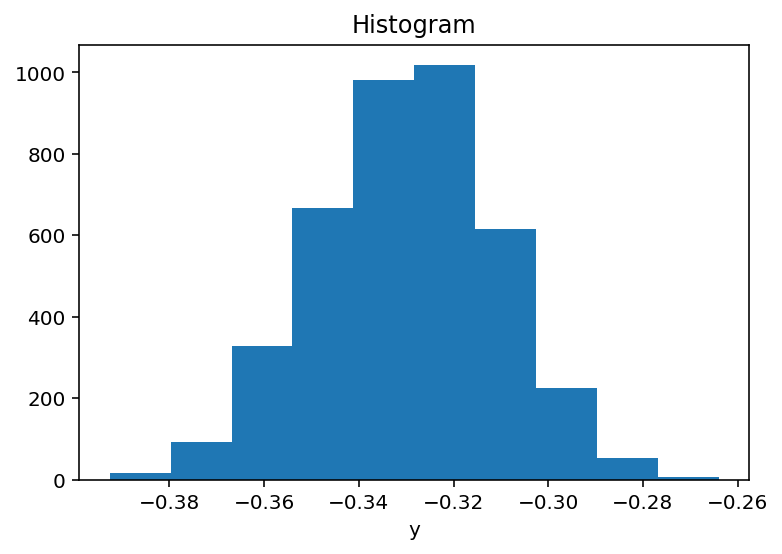

In [46]:
log_lik__i[:,:, 0].plot.hist() # quick plot of this log likelihood

In [40]:
_ess(log_lik__i[:,:, 0], relative=True)

0.6132749228044678

In [39]:
_ess(log_lik__i[:,:, 99], relative=True)

0.6423414726596139

v_i of the second observation in R: -0.7407794

In [47]:
log_lik__i[:,:, 0].mean()

<xarray.DataArray 'y' ()>
array(-0.32995913)
Coordinates:
    switch   int64 0

The log likelihood do not differ a lot between R and Python, but the output of `_ess` does. 

I then export the log likelihood of the first obervation to csv and calculated the r_eff in R, the results is the same. 

So, the problem is in the log likelihood!!!

In [63]:
ary = np.asarray(r_lik, dtype=float)
ary

array([[-0.34406096, -0.32916256, -0.35464297, ..., -0.33035862,
        -0.33586764, -0.32889021],
       [-0.3332834 , -0.29563629, -0.32479094, ..., -0.36454971,
        -0.32793516, -0.32429385],
       [-0.32020536, -0.35430736, -0.3394602 , ..., -0.32198527,
        -0.3128094 , -0.33483171],
       [-0.32647858, -0.34403682, -0.32958952, ..., -0.348219  ,
        -0.33211473, -0.32397569]])

In [64]:
n_chain, n_draw = ary.shape

In [65]:
n_chain

4

In [66]:
n_draw

1000

In [62]:
r_lik = pd.read_csv("tmp_1_2.csv").T # read the csv save from log likelihood from R
r_lik.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
V1,-0.344061,-0.329163,-0.354643,-0.304761,-0.325596,-0.313075,-0.342178,-0.302794,-0.351548,-0.330954,...,-0.318015,-0.317005,-0.357987,-0.301080,-0.304215,-0.328836,-0.357070,-0.330359,-0.335868,-0.328890
V2,-0.333283,-0.295636,-0.324791,-0.331367,-0.393010,-0.345157,-0.348027,-0.324875,-0.335290,-0.319887,...,-0.376287,-0.322731,-0.319574,-0.309777,-0.332836,-0.311077,-0.316428,-0.364550,-0.327935,-0.324294
V3,-0.320205,-0.354307,-0.339460,-0.338015,-0.361239,-0.313238,-0.312901,-0.331427,-0.352207,-0.334479,...,-0.335326,-0.334416,-0.345888,-0.307138,-0.353454,-0.296659,-0.312815,-0.321985,-0.312809,-0.334832
V4,-0.326479,-0.344037,-0.329590,-0.361815,-0.325571,-0.322688,-0.320192,-0.359506,-0.358297,-0.346316,...,-0.313668,-0.318525,-0.332657,-0.345203,-0.318350,-0.314121,-0.328471,-0.348219,-0.332115,-0.323976


In [69]:
np.mean(np.mean(r_lik))

-0.3311735672835377

In [68]:
_ess(r_lik, relative=True)

0.9965118715180641

In [41]:
log_lik__i[:,:, 99].to_pandas().to_csv('tmp_100.csv', index=False) 

In [42]:
_ess(log_lik__i[:,:, 99], relative=True)  # R: 0.8462781

0.6423414726596139

In [20]:
_ess(log_lik__i[:,:, 1], relative=True) # R 1.04021

0.5332543633667599

In [14]:
from arviz.stats.stats_utils import not_valid as _not_valid
from arviz.stats.stats_utils import autocov as _autocov
from arviz.stats.stats_utils import stats_variance_2d as svar
from arviz.utils import Numba, _numba_var, _stack, _var_names

def _z_scale(ary):
    """Calculate z_scale.
    Parameters
    ----------
    ary : np.ndarray
    Returns
    -------
    np.ndarray
    """
    ary = np.asarray(ary)
    rank = stats.rankdata(ary, method="average")
    rank = _backtransform_ranks(rank)
    z = stats.norm.ppf(rank)
    z = z.reshape(ary.shape)
    return z

def _ess(ary, relative=False):
    """Compute the effective sample size for a 2D array."""
    _numba_flag = Numba.numba_flag
    ary = np.asarray(ary, dtype=float)
    if _not_valid(ary, check_shape=False):
        return np.nan
    if (np.max(ary) - np.min(ary)) < np.finfo(float).resolution:  # pylint: disable=no-member
        return ary.size
    if len(ary.shape) < 2:
        ary = np.atleast_2d(ary)
    n_chain, n_draw = ary.shape
    acov = _autocov(ary, axis=1)
    chain_mean = ary.mean(axis=1)
    mean_var = np.mean(acov[:, 0]) * n_draw / (n_draw - 1.0)
    var_plus = mean_var * (n_draw - 1.0) / n_draw
    if n_chain > 1:
        var_plus += _numba_var(svar, np.var, chain_mean, axis=None, ddof=1)

    rho_hat_t = np.zeros(n_draw)
    rho_hat_even = 1.0
    rho_hat_t[0] = rho_hat_even
    rho_hat_odd = 1.0 - (mean_var - np.mean(acov[:, 1])) / var_plus
    rho_hat_t[1] = rho_hat_odd

    # Geyer's initial positive sequence
    t = 1
    while t < (n_draw - 3) and (rho_hat_even + rho_hat_odd) > 0.0:
        rho_hat_even = 1.0 - (mean_var - np.mean(acov[:, t + 1])) / var_plus
        rho_hat_odd = 1.0 - (mean_var - np.mean(acov[:, t + 2])) / var_plus
        if (rho_hat_even + rho_hat_odd) >= 0:
            rho_hat_t[t + 1] = rho_hat_even
            rho_hat_t[t + 2] = rho_hat_odd
        t += 2

    max_t = t - 2
    # improve estimation
    if rho_hat_even > 0:
        rho_hat_t[max_t + 1] = rho_hat_even
    # Geyer's initial monotone sequence
    t = 1
    while t <= max_t - 2:
        if (rho_hat_t[t + 1] + rho_hat_t[t + 2]) > (rho_hat_t[t - 1] + rho_hat_t[t]):
            rho_hat_t[t + 1] = (rho_hat_t[t - 1] + rho_hat_t[t]) / 2.0
            rho_hat_t[t + 2] = rho_hat_t[t + 1]
        t += 2

    ess = n_chain * n_draw
    tau_hat = -1.0 + 2.0 * np.sum(rho_hat_t[: max_t + 1]) + np.sum(rho_hat_t[max_t + 1 : max_t + 2])
    tau_hat = max(tau_hat, 1 / np.log10(ess))
    ess = (1 if relative else ess) / tau_hat
    if np.isnan(rho_hat_t).any():
        ess = np.nan
    return ess

In [44]:
r_eff_new 

[0.6132749228044678,
 0.5332543633667599,
 0.6461211168399352,
 0.5746649498573583,
 0.6314364797013551,
 0.6062317274556813,
 0.7528670526207321,
 0.6451180832130511,
 0.634163719132099,
 0.8844696718114992,
 0.5958022553758414,
 0.6135195707700476,
 0.7302129768081335,
 0.6929206446379635,
 1.0989281923741134,
 0.9629450758388741,
 0.9185973054519766,
 0.9099827275319563,
 0.8494403418745179,
 0.6245141727439447,
 0.767861989544595,
 0.6909576289884639,
 0.8612914164962496,
 0.7865791522539312,
 1.057101514102809,
 0.931129078253888,
 0.6776823573369215,
 0.7230392253250431,
 0.560324928711145,
 0.6364095137932083,
 0.67102177928653,
 0.5778042812693637,
 0.6663704272955754,
 0.7448757027649182,
 0.5720485320444799,
 0.6251681280022081,
 0.7349016495897452,
 0.7540882917502602,
 0.7672176438992516,
 0.6381493806992566,
 0.7533200461329865,
 0.6968789774654895,
 0.5788561397606391,
 0.6016733013146521,
 0.6989260782534601,
 0.5659332288493562,
 0.5706521527627595,
 0.8456470436291876,

In [45]:
np.mean(r_eff_new)

0.6323435744648012

In [ ]:
tmp_ll = log_lik__i[:,:, 0]  # get the log likelihood of the first observation
tmp_ll

In [ ]:
r_eff = az.ess(idata, method="identity", relative=True)  # this calculate the relative ess for the first observation?
r_eff

In [ ]:
print(az.__version__)

In [ ]:
r_eff2 = _ess(tmp_ll, relative=True)

In [ ]:
r_eff2